# ZRE - Practicals 2

In [1]:
!wget https://codeload.github.com/Marek324/butfit-zre-labs/zip/refs/heads/master -O repo.zip
!unzip repo.zip "butfit-zre-labs-master/*" -d repo
!mv repo/butfit-zre-labs-master/* .
!rm -rf repo.zip repo *.md cv*

--2025-05-17 13:39:16--  https://codeload.github.com/Marek324/butfit-zre-labs/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.116.9
Connecting to codeload.github.com (codeload.github.com)|140.82.116.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘repo.zip’

repo.zip                [     <=>            ]  15.11M  11.4MB/s    in 1.3s    

2025-05-17 13:39:18 (11.4 MB/s) - ‘repo.zip’ saved [15843112]

Archive:  repo.zip
a155ef4fecc738ae0ab2f3d24d6c06ea39b76927
   creating: repo/butfit-zre-labs-master/
 extracting: repo/butfit-zre-labs-master/.gitignore  
 extracting: repo/butfit-zre-labs-master/.python-version  
  inflating: repo/butfit-zre-labs-master/.venv_req.txt  
 extracting: repo/butfit-zre-labs-master/README.md  
   creating: repo/butfit-zre-labs-master/audio/
  inflating: repo/butfit-zre-labs-master/audio/buongiorno16.wav  
  inflating: repo/butfit-zre-labs-master/audio/michia

In [2]:
import numpy as np
import numpy.random as rd
import scipy
import scipy.stats as st
import scipy.signal as sg
import matplotlib.pyplot as plt
import importlib
import librosa
from zre_lib import zre
from IPython.display import Audio, display


# Part 1: Modelling speech - The LPC method



## 1.1 Prepare the signal and calculate autocorrelation coefficients

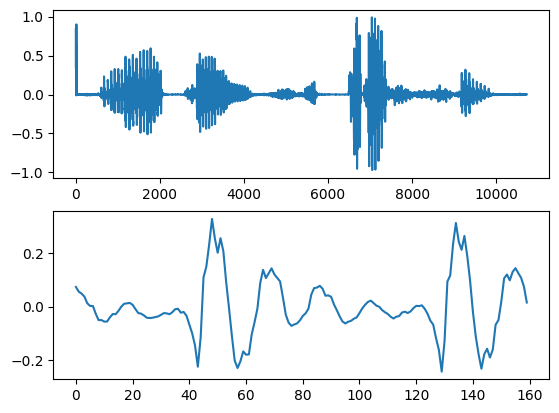

In [3]:
test_file = f'audio/test.wav'
s, Fs = librosa.load(test_file, sr=8000)
sm = s - np.mean(s)
f, ax = plt.subplots(2,1)
ax[0].plot(sm)
sr = zre.frame(sm, 160, 0)
x = sr[6]
ax[1].plot(x)
plt.show()

In [4]:
Audio(x, rate=Fs)

#### Autocorrelation coefficients

$$ R_{yy}(k) = \sum_{n = 0}^{N-1-k} y(n)y(n-k) $$



#### Q1: Why do we need autocorrelation coefficients for LPC?

To effectively calculate LPC coefficients

In [5]:
# Set parameters
N = len(x)
P = 10

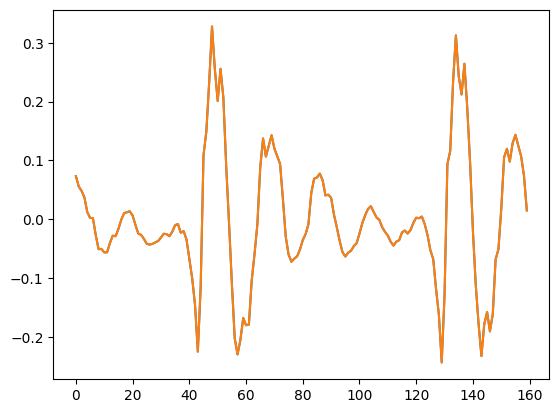

In [6]:
# np.pad examples
k = 0
plt.plot(np.pad(x, (0,k)))
plt.plot(np.pad(x, (k,0)))
plt.show()
k += 1

Calculation of autocorrelation from definition

In [7]:
# Autocorrelation for positive range of k
R = []
for i in range(N):
    x2 = np.pad(x, (i,0), 'constant')[0:N]
    R.append(np.sum(x*x2))

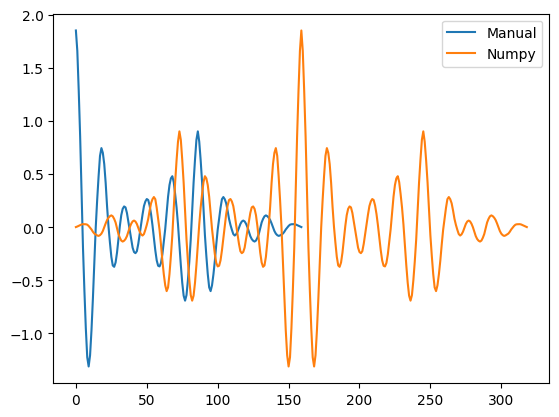

In [8]:
Reasy = np.array([np.sum(x[i:]*x[:len(x)-i]) for i in range(N+1)])
Rnp = np.correlate(x, x, 'full')

plt.plot(R)
plt.plot(Rnp)
plt.legend(['Manual','Numpy'])
plt.show()

#### Q2: Which coefficients do we need? Why?

Only the second half, because the signal is correlated with itself so the coefficients are the same (just mirrored)

## 1.2 Calculate LPC coefficients
We need to calculate the filters coefficients $a_1$ to $a_P$ from the equations 17, 18

![image.png](attachment:image.png)

#### Q1 : How should we choose the predictor's order? What happens if use a second order predictor?

The error doesn't change as much with higher orders, it's not worth to compute higher orders.

#### Q2 : Why is the A(z) filter called whitening filter? What information gets removed from the input signal x[n]?

Spectral envelope is removed, leaving only higher frequencies which resemble white noise.

Matrix $\Phi(i,j)$, for $1\leq j\leq P$ where P is the filter order, for $Fs = 8 kHz is usually P = 10



In [9]:
P = 10
phi = scipy.linalg.toeplitz(R[:P-1])


#### Method 1: Solve the linear system

In [10]:
R = np.array(R)
adirect = np.matmul(np.linalg.inv(phi),-R[1:P])
print(adirect.shape)
adirect = np.hstack([[0], adirect])
adirect.shape

(9,)


(10,)

#### Method 2: Levinson - Durbin algorithm

![image.png](attachment:image.png)

In [11]:
A = np.zeros((P,P)) # (iteration, value)
E = np.zeros(P+1)

E[0] = R[0] # 22
for i in range(1,P):
    suma = np.sum([A[i - 1, j]*R[i - j] for j in range(i)])
    ki = - (R[i] + suma) / E[i - 1] # 23
    A[i,i] = ki                     # 24
    for j in range(i):
        A[i, j] = A[i - 1, j] + ki * A[i - 1, i-j]      # 25
    E[i] = (1-ki**2)*E[i - 1]       # 26


#### Method 3: Librosa LPC function via Burg's method


In [12]:
lpc_coeff = np.hstack([[0], librosa.lpc(x, order=P-1)[1:]])

#### Compare methods

In [13]:
print(f'Manual calculation of linear system: {np.round(adirect, 2)}')
print(f'Levinson-Durbin algorithm:           {np.round(A[-1,:], 2)}')
print(f'Librosa lpc function:                {np.round(lpc_coeff, 2)}')

# Filters' coefficients:
bd = -adirect
bl = -np.hstack([[0], librosa.lpc(x, order=P-1)[1:]])
bld = -A[-1,:]


Manual calculation of linear system: [ 0.   -1.38  0.83 -0.7   0.77 -0.31 -0.03  0.01  0.24 -0.07]
Levinson-Durbin algorithm:           [ 0.   -1.38  0.83 -0.7   0.77 -0.31 -0.03  0.01  0.24 -0.07]
Librosa lpc function:                [ 0.   -1.41  0.92 -0.82  0.89 -0.42  0.05 -0.06  0.27 -0.07]


#### Method 4: Neural Network LPC implementation

 15%|█▌        | 924/6000 [00:00<00:04, 1172.11it/s]

1000
network: [ 0.    1.36 -0.79  0.64 -0.69  0.23  0.1  -0.06 -0.2   0.06]
librosa: [-0.    1.41 -0.92  0.82 -0.89  0.42 -0.05  0.06 -0.27  0.07]
   true: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]
lev-dur: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]


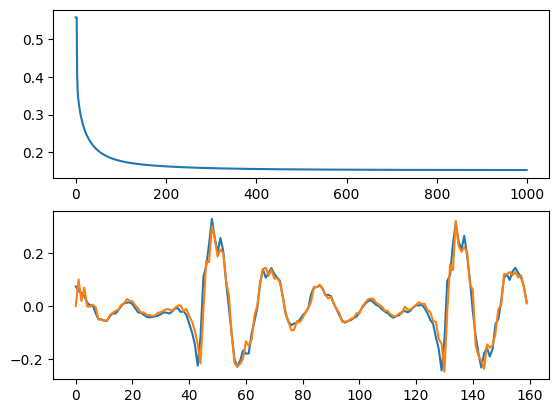

 32%|███▏      | 1896/6000 [00:01<00:02, 1405.54it/s]

2000
network: [ 0.    1.37 -0.82  0.7  -0.76  0.3   0.05 -0.02 -0.23  0.07]
librosa: [-0.    1.41 -0.92  0.82 -0.89  0.42 -0.05  0.06 -0.27  0.07]
   true: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]
lev-dur: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]


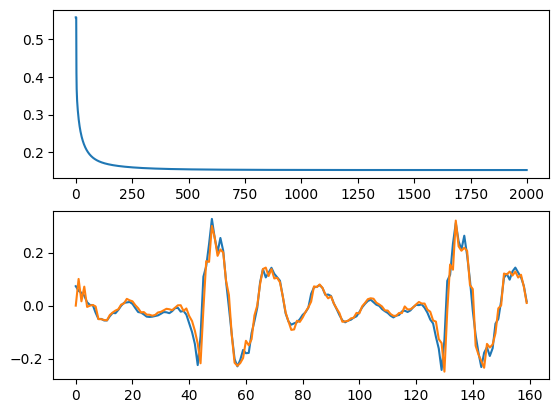

 49%|████▉     | 2953/6000 [00:02<00:01, 1585.49it/s]

3000
network: [ 0.    1.37 -0.83  0.7  -0.76  0.31  0.04 -0.01 -0.24  0.07]
librosa: [-0.    1.41 -0.92  0.82 -0.89  0.42 -0.05  0.06 -0.27  0.07]
   true: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]
lev-dur: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]


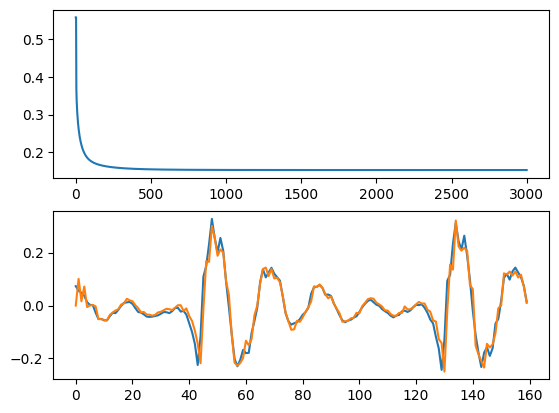

 64%|██████▍   | 3845/6000 [00:03<00:01, 1535.44it/s]

4000
network: [ 0.    1.38 -0.83  0.7  -0.77  0.31  0.04 -0.01 -0.24  0.07]
librosa: [-0.    1.41 -0.92  0.82 -0.89  0.42 -0.05  0.06 -0.27  0.07]
   true: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]
lev-dur: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]


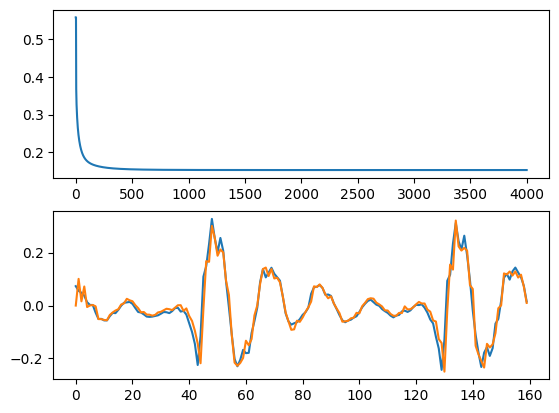

 81%|████████▏ | 4889/6000 [00:03<00:00, 1546.65it/s]

5000
network: [ 0.    1.38 -0.83  0.7  -0.77  0.31  0.04 -0.01 -0.24  0.07]
librosa: [-0.    1.41 -0.92  0.82 -0.89  0.42 -0.05  0.06 -0.27  0.07]
   true: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]
lev-dur: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]


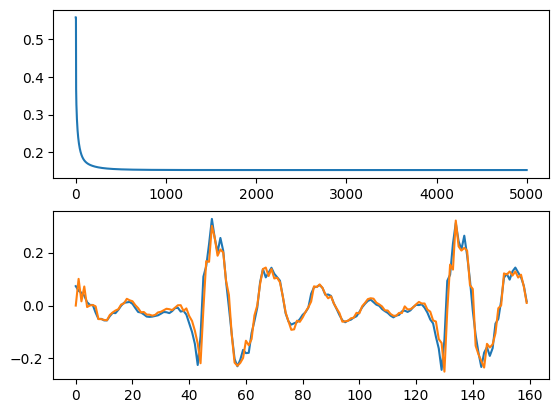

 98%|█████████▊| 5903/6000 [00:05<00:00, 1344.34it/s]

6000
network: [ 0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]
librosa: [-0.    1.41 -0.92  0.82 -0.89  0.42 -0.05  0.06 -0.27  0.07]
   true: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]
lev-dur: [-0.    1.38 -0.83  0.7  -0.77  0.31  0.03 -0.01 -0.24  0.07]


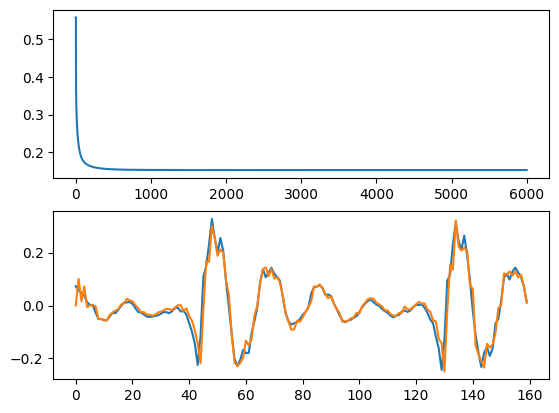

100%|██████████| 6000/6000 [00:05<00:00, 1135.55it/s]


In [14]:
import torch
import torch.nn as nn
import tqdm

class lpc(torch.nn.Module):
    def __init__(self, kernel):
        super().__init__()
        self.conv = nn.Conv1d(1,1,kernel_size=kernel, bias=False)
    def forward(self, x):
        return self.conv(x)

kernel = P - 1
ten_x = torch.from_numpy(x).type(torch.float32).unsqueeze(0)
ten_x = torch.cat([torch.zeros((1,kernel)), ten_x, torch.zeros((1,kernel))], dim=1)

net = lpc(kernel).train()

optim = torch.optim.SGD(net.parameters(), lr=0.1)
criterion = nn.L1Loss()
losses = []
iterator = None
for i in tqdm.tqdm(range(6000)):
    optim.zero_grad()
    # pozor ten_x je vypaddovany
    loss = torch.sum((net(ten_x.unsqueeze(0))[:,:,:ten_x.size(1)-kernel] + ten_x[:,kernel:])**2)
    losses.append(loss.item())
    loss.backward()
    optim.step()
    if ((i + 1)%1000) == 0 and True:
        print(i+1)
        fig, ax = plt.subplots(2,1)
        ax[0].plot(sg.medfilt(losses, 5))
        b = next(net.conv.parameters()).detach().squeeze().numpy()
        b = np.hstack([[0], -1*np.flip(b)])
        print(f'network: {np.round(b, 2)}')
        print(f'librosa: {np.round(bl, 2)}')
        print(f'   true: {np.round(bd, 2)}')
        print(f'lev-dur: {np.round(bld, 2)}')

        ax[1].plot(x)
        ax[1].plot(sg.lfilter(b, [1], x))
        plt.show()


In [15]:
bnet = next(net.conv.parameters()).detach().squeeze().numpy()
bnet = np.hstack([[0], -1*np.flip(bnet)])


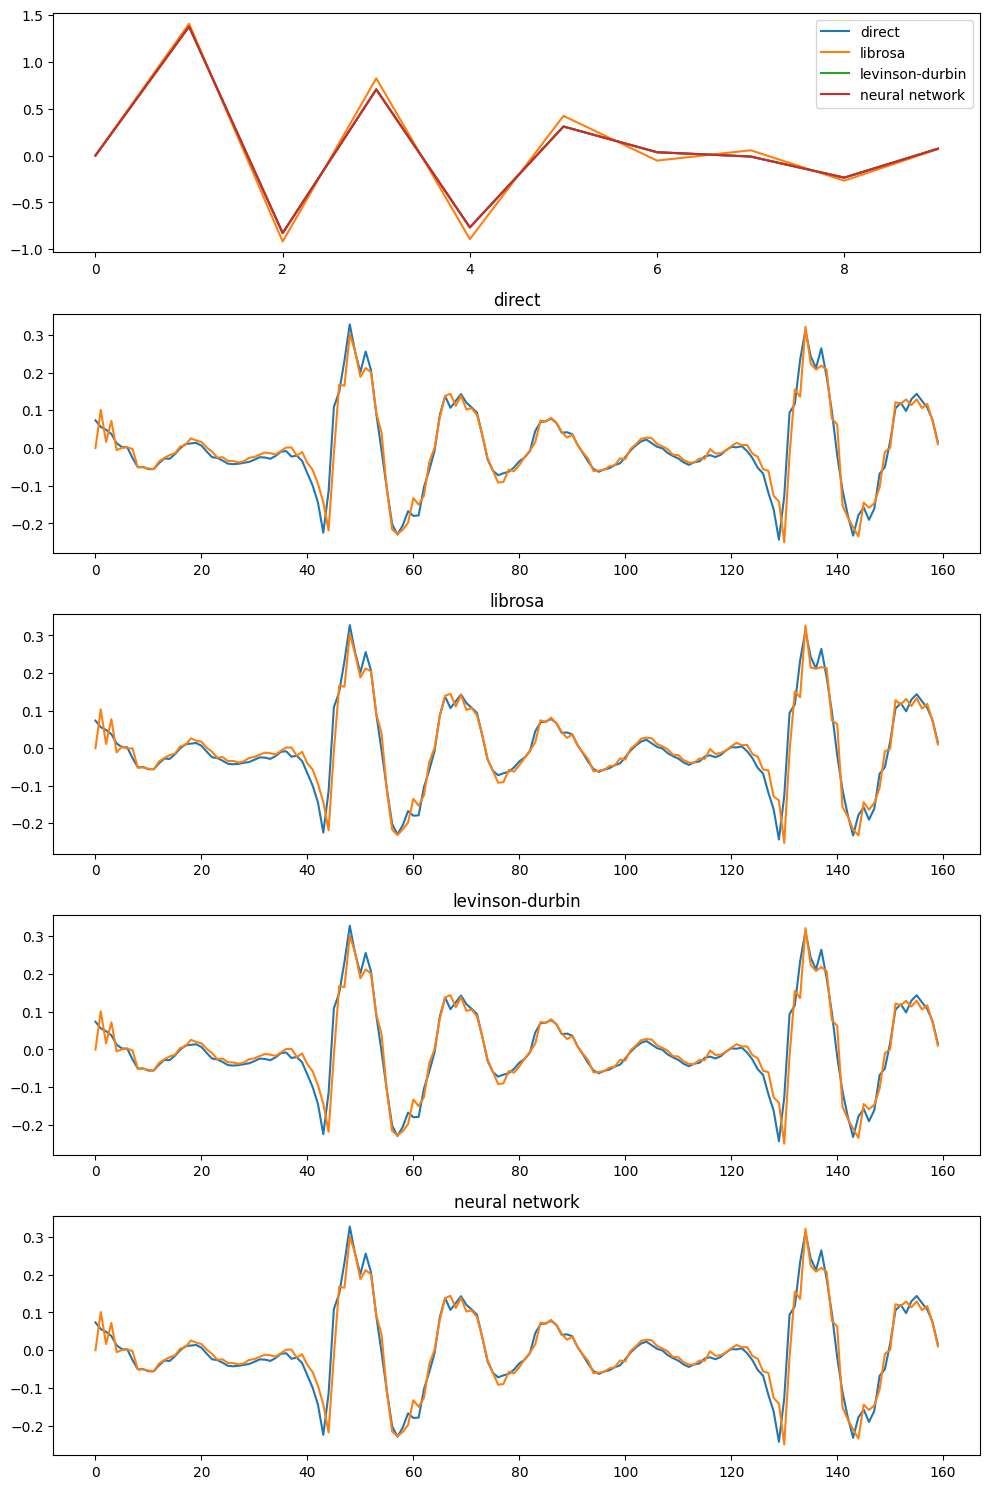

In [16]:
fig, ax= plt.subplots(5,1, figsize=(10,15))
ax[0].plot(bd, label='direct')
ax[0].plot(bl, label='librosa')
ax[0].plot(bld, label='levinson-durbin')
ax[0].plot(bnet, label='neural network')
ax[0].legend()

ax[1].set_title('direct')
ax[1].plot(x)
ax[1].plot(sg.lfilter(bd, [1], x))

ax[2].set_title('librosa')
ax[2].plot(x)
ax[2].plot(sg.lfilter(bl, [1], x))

ax[3].set_title('levinson-durbin')
ax[3].plot(x)
ax[3].plot(sg.lfilter(bld, [1], x))

ax[4].set_title('neural network')
ax[4].plot(x)
ax[4].plot(sg.lfilter(bnet, [1], x))

plt.tight_layout()
plt.show()

## 1.3 Prediction error E

We got the filter - let's check the error between the prediction and the real signal. The best way to do so, is to check the energy of the error signal $e[n]$

#### Q1: How can we calculate the energy of the feedback signal?

$$ E = \sum_0^Ne^2(n)

#### a) Calculate the error and its energy

In [17]:
A_z = librosa.lpc(x, order=P-1)
e_filter = sg.lfilter(A_z, [1], x)
e_F = np.sum(e_filter**2)
print(f'Error of the filter: {e_F}')

Error of the filter: 0.1493692405888269


#### b) Check the the energy output from LD implementation

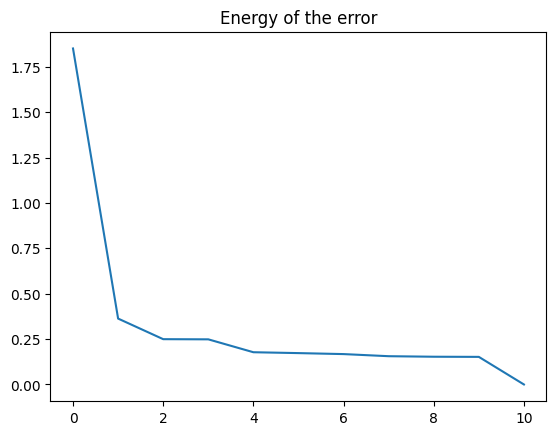

In [18]:
plt.plot(E)
plt.title("Energy of the error")
e_LD = E[-2]
plt.show()

#### c) Energy equation from LPC (page 22/39):
![image.png](attachment:image.png)

In [19]:
e_eq = R[0] + np.sum(A[-1,1:]*R[1:10])
print(f'Energy according to eq. 20: {e_eq}')

Energy according to eq. 20: 0.15200798960058637


## 1.4 LPC spectrum

#### a) FFT spectrum

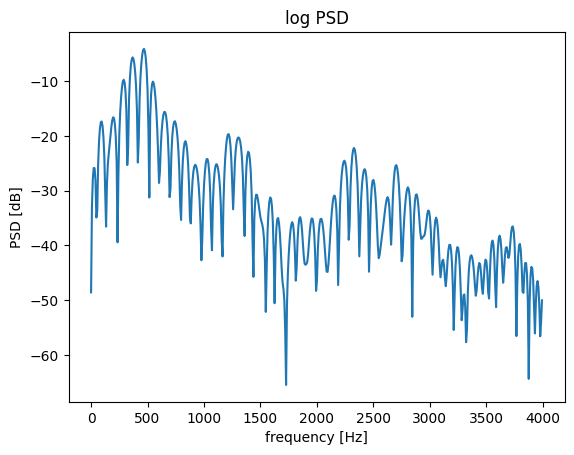

In [20]:
f = np.arange(512)/1024 * Fs
PSD = np.abs(np.fft.fft(x, n=1024)[:512])**2/160
PSDlog = 10 * np.log10(PSD)
plt.plot(f, PSDlog)
plt.title("log PSD")
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [dB]")
plt.show()

#### b) LPC spectrum
$$
\hat{G}_{LPC}(f) = \left|\frac{G}{A(z)}\right|^2_{z=e^{j2\pi f}} = \frac{E}{N}\frac{1}{|A(z)|^2},
$$

where $f$ is the normalized frequency $f = F/F_S$.

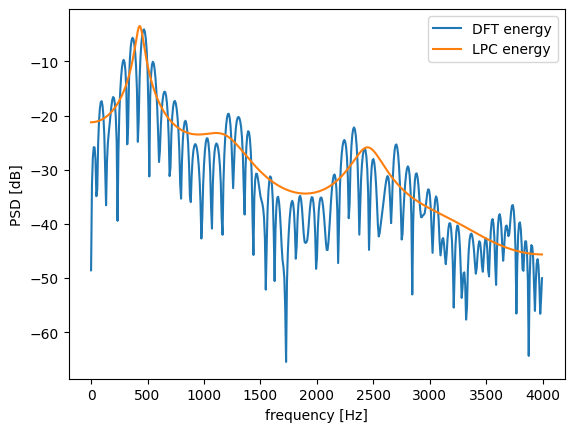

In [21]:
Gain = np.sqrt(e_eq/N)
h = sg.freqz(Gain, A_z, 512)[1] # filter's frequency response
Glpc = np.abs(h)**2 # filter's energy
Glpclog = 10*np.log10(Glpc)
plt.plot(f,PSDlog, label = "DFT energy")
plt.plot(f, Glpclog, label = "LPC energy")
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [dB]")
plt.legend()
plt.show()

Text(0.5, 1.0, 'LPC error spectrum')

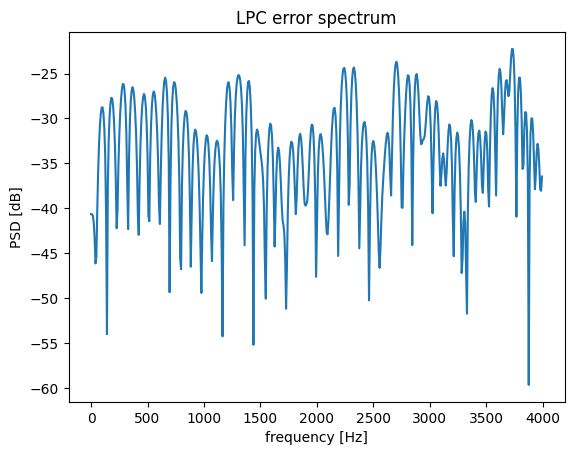

In [22]:
# residual
E = np.fft.fft(e_filter, n=1024)[:512]
Gdft = (np.abs(E)**2)/170
Gdftlog = 10 * np.log10(Gdft)
plt.plot(f, Gdftlog)
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [dB]")
plt.title("LPC error spectrum")

#### Q1 : What does the LPC spectrum represent?

It is a representation of the spectral envelope(vocal tract transfer function).

#### Q2 : What does the A(z) filter do with the signal spectrum?

Removes spectral envelope.
Leaves excitation signal.

#### Q3 : Check the error spectrum - are there any correlations and if so, which ones?

Excitation signal which is correlated to fundamental frequency is left as an error.

## 1.5 Synthesis

In [23]:
# LPC of the whole signal All coefficients and Gall residual error
Aall = np.zeros((sr.shape[1], P))
Gall = np.zeros((sr.shape[1], 1))

for i in range(sr.shape[0]):
    a = librosa.lpc(sr[i], order=P-1)
    e = sg.lfilter(a, [1], sr[i])
    Aall[i] = a
    Gall[i] = np.sqrt(np.sum(e**2))


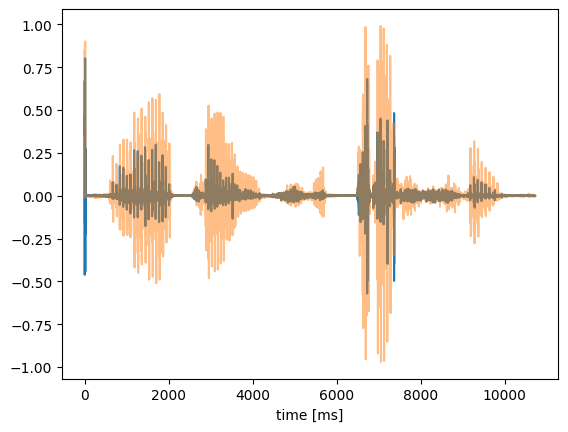

In [24]:
# filtering of the original signal with LPC filter s_new(n)
init = np.zeros(P-1)
ebig = []

for i in range(sr.shape[0]):
    x = sr[i]
    a = Aall[i]
    e, final = sg.lfilter(a, [1], x, zi=init)
    init = final
    ebig.append(e)
ebig = np.hstack(ebig)
plt.plot(ebig)
plt.plot(sm, alpha=0.5) # original signal
plt.xlabel("time [ms]")
plt.show()

In [25]:
Audio(ebig, rate=Fs)

In [26]:
def plot_spectrogram(sig, Fs):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    f, t, spec = sg.spectrogram(sig, fs=Fs, nfft=256, mode='psd')
    # default window is Tukey, nperseg = 256, noverlap = 256/8

    plt.pcolormesh(t, f, 10*np.log10(spec))

    ax.set_ylabel('frequency [Hz]')
    ax.set_xlabel('time [s]')
    plt.tight_layout()

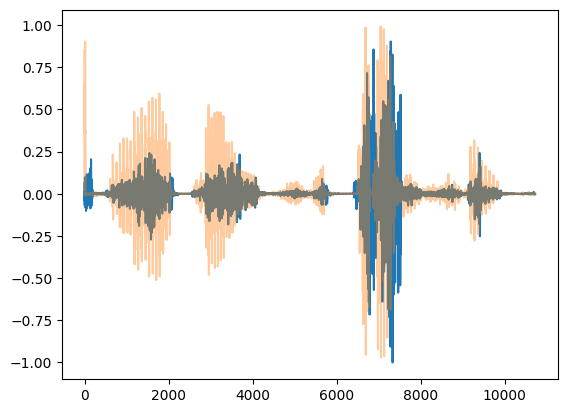

In [27]:
# do some synthesis with white noise!
init = np.zeros(P-1)
syntbig = []
for i in range(sr.shape[0]):
    a = Aall[i]
    G = Gall[i]
    excit = np.random.normal(size=sr.shape[1]) # white noise
    synt, final = sg.lfilter(G, a, excit, zi=init) # zi is the delay
    init = final
    syntbig.append(synt)
syntbig = np.hstack(syntbig)
plt.plot(syntbig/np.max(np.abs(syntbig)))
plt.plot(sm, alpha=0.4)
plt.show()

In [28]:
Audio(syntbig, rate=Fs)

#### Q1: What happens if we change excitation? For example if use a violin recording as excitation signal?

 `violin8k.wav`

http://ccrma.stanford.edu/~jos/waveguide/Sound_Examples.html

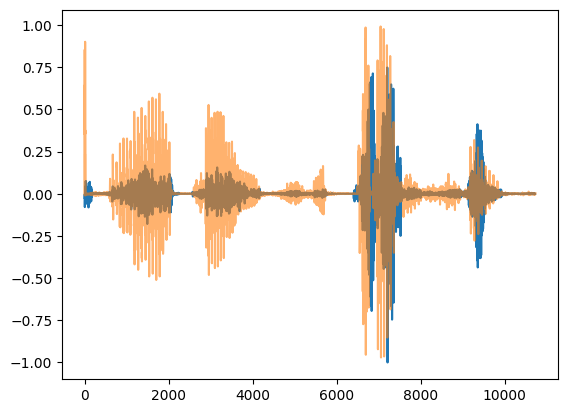

In [29]:
v = librosa.load(f'audio/violin8k.wav', sr=8000)[0]
vm = v - v.mean()
vr = zre.frame(vm, 160, 0) # no overlap

init = np.zeros(P-1)
syntvio = []
for i in range(sr.shape[0]):
    a = Aall[i]
    G = Gall[i]
    excit = vr[i] + 0.1 * rd.normal(size=vr[i].shape)
    excit /= np.sqrt(np.sum(excit**2)/160)
    # print(np.sum(excit**2)/160)
    synt, final = sg.lfilter(G, a, excit, zi=init)
    init = final
    syntvio.append(synt)
syntvio = np.hstack(syntvio)
plt.plot(syntvio/np.max(np.abs(syntvio)))
plt.plot(sm, alpha=0.6)
plt.show()

In [30]:
Audio(syntvio, rate=Fs)

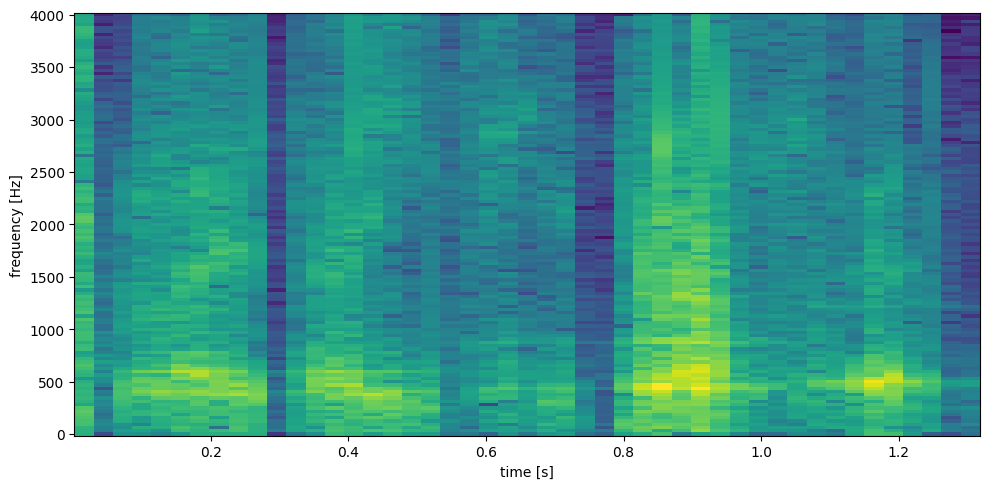

In [31]:
plot_spectrogram(syntvio, Fs)

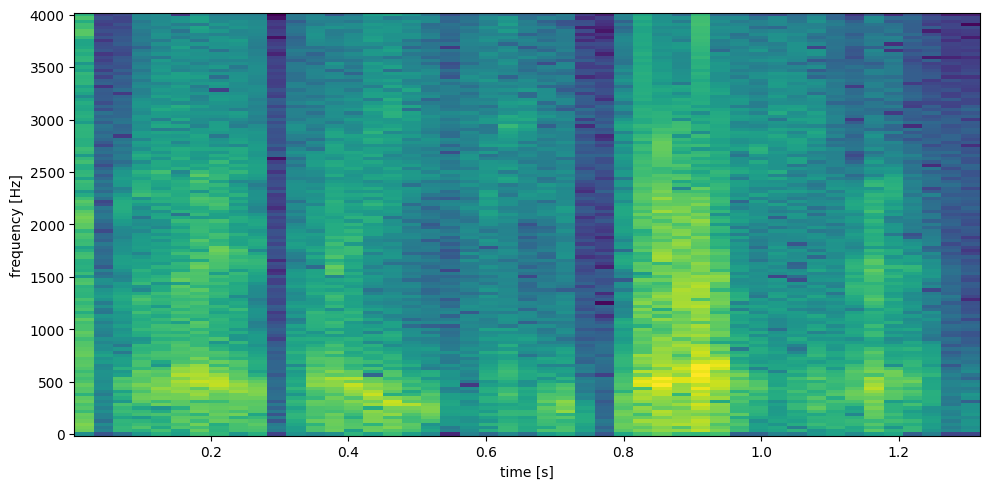

In [32]:
plot_spectrogram(syntbig, Fs)

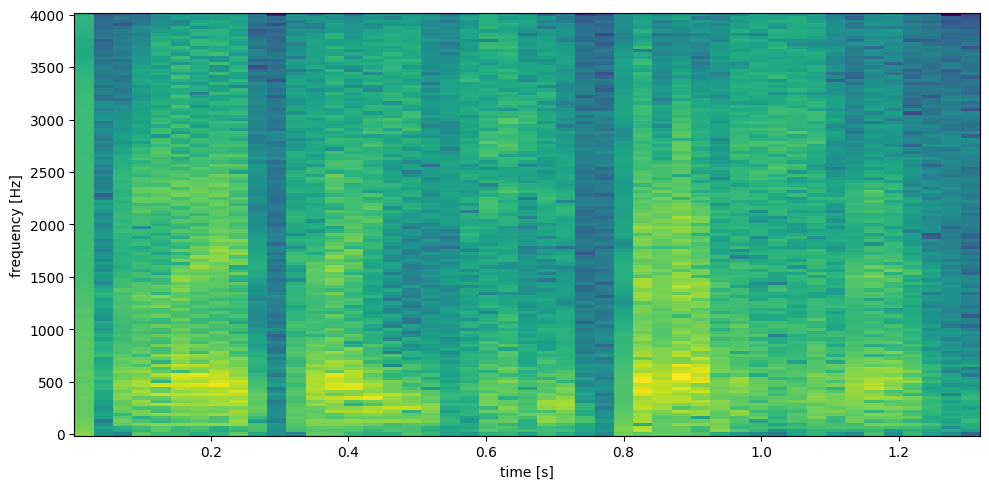

In [33]:
plot_spectrogram(sm, Fs)

#### Q2 : What happens if the excitation signal's power is not normalized ( = 1)?

If the power of the energy is too high, it can lead to clipping.

#### Q3 : Try to add white noise to the excitation violin signal. What changes? Why?

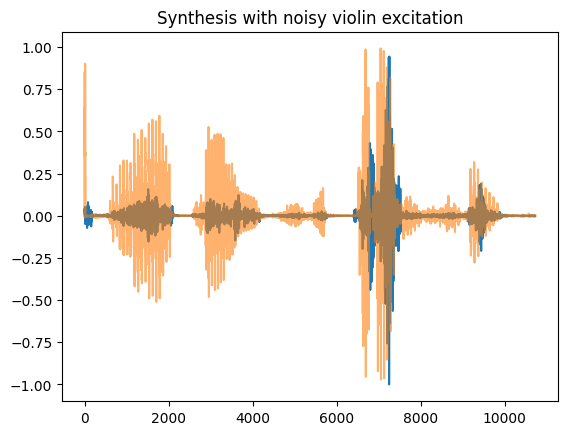

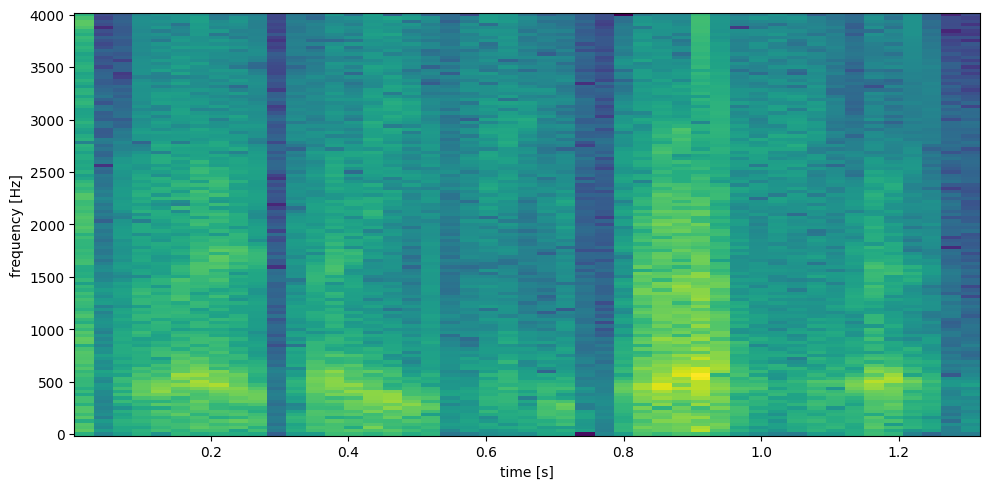

In [34]:
init = np.zeros(P-1)
syntvio_noise = []
noise_level = 0.3

for i in range(sr.shape[0]):
    a = Aall[i]
    G = Gall[i]
    # Add more noise to the violin excitation signal
    excit = vr[i] + noise_level * rd.normal(size=vr[i].shape)
    # Normalize power
    excit /= np.sqrt(np.sum(excit**2)/160)
    synt, final = sg.lfilter(G, a, excit, zi=init)
    init = final
    syntvio_noise.append(synt)

syntvio_noise = np.hstack(syntvio_noise)
plt.plot(syntvio_noise/np.max(np.abs(syntvio_noise)))
plt.plot(sm, alpha=0.6)
plt.title("Synthesis with noisy violin excitation")
plt.show()

# Play the audio
display(Audio(syntvio_noise, rate=Fs))

# Show spectrogram
plot_spectrogram(syntvio_noise, Fs)

# PART 2: Vector Quantization

Let's use the following functions:
- zre.vq_code - for vector coding according to a codebook
- zre.vq_clust - calculates centroids from the training vectors and clusters
- zre.vq_split - splits the codebook


In [35]:
lcp_l = 10
A, G, Nram = zre.param(f'audio/train.wav', 160, 0, lcp_l)
x_test = librosa.load(f'audio/testspdat.wav', sr=Fs)[0]
At, Gt, Nramt = zre.param(f'audio/testspdat.wav', 160, 0, lcp_l)

[[ 0.0487368   0.44443882  0.01277773  0.26173902  0.04188567  0.43389437
  -0.22028227  0.25216037  0.03080785  0.0375869 ]] [0 0 0 ... 0 0 0]
Global distance: 2.895894584666837


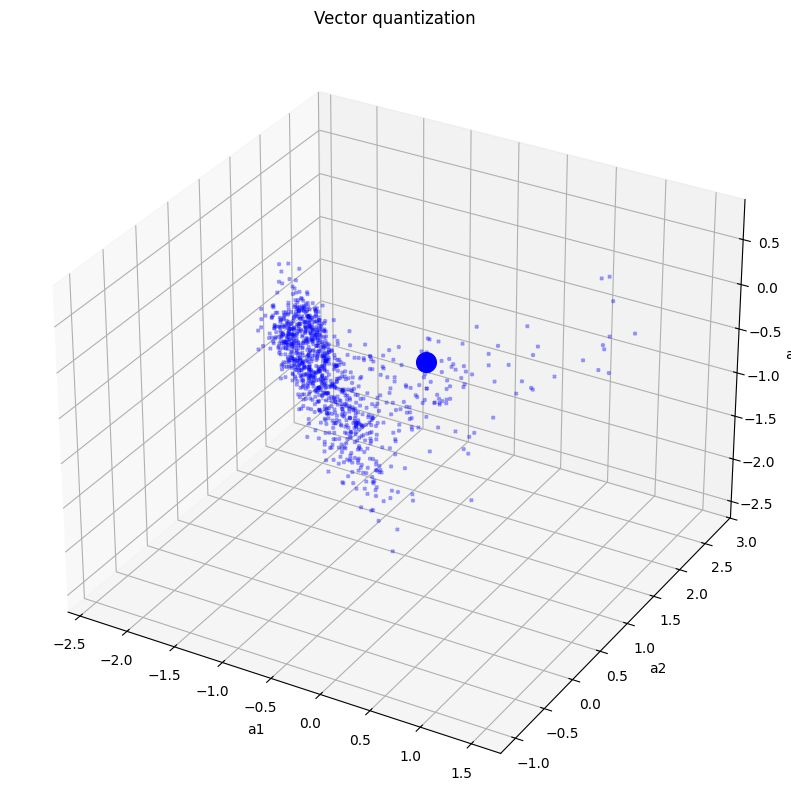

[[-0.94979823  0.5509186  -0.48240667  0.11551745  0.07314191  0.09098021
  -0.16439834  0.18667604 -0.02267996  0.01108925]] [0 0 0 ... 0 0 0]
Global distance: 1.4913547506780693
Vectors per codebook: [1026.]


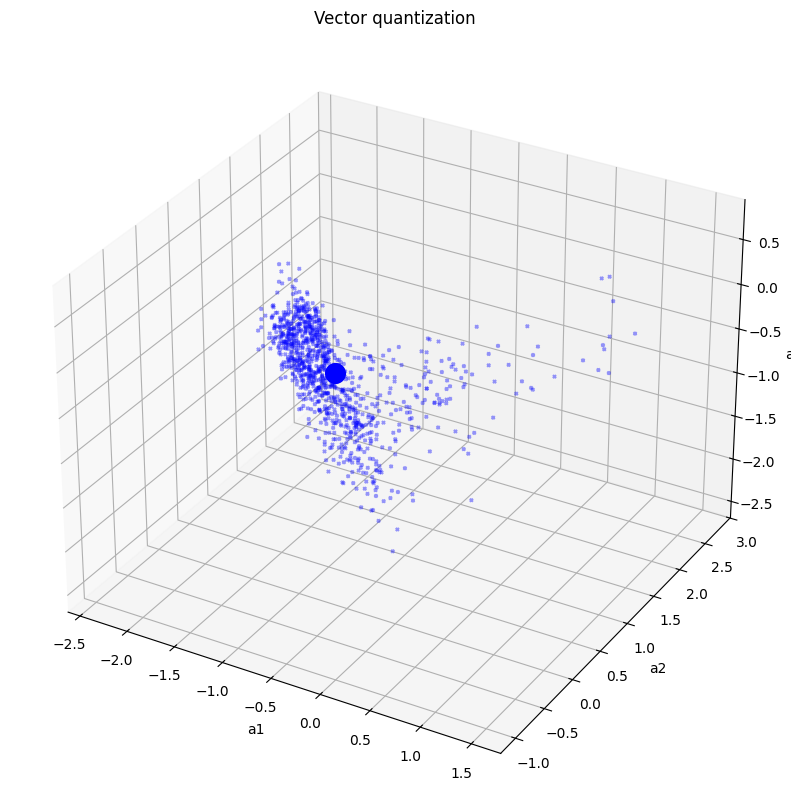

In [36]:
# Example:
data = A
codebook = data[rd.randint(data.shape[0])][np.newaxis, :]
idx_s, gd = zre.vq_code(data, codebook)
print(codebook, idx_s)
print(f'Global distance: {gd}')
zre.show(data, codebook, idx_s)


codebook, nbs = zre.vq_clust(data, idx_s, 1)
idx_s, gd = zre.vq_code(data, codebook)
print(codebook, idx_s)
print(f'Global distance: {gd}')
print(f'Vectors per codebook: {nbs}')
zre.show(data, codebook, idx_s)

## 2.1 Train a Codebook with 8 vectors and random initialization

In [37]:
A.shape
sm.shape

(10731,)

(8, 10)
Global distance: 1.1070163231256165
Global distance: 0.7937448445829164
Global distance: 0.6877636853891176
Global distance: 0.639791845472153
Global distance: 0.6165726804359027
Global distance: 0.601288470065332
Global distance: 0.5936868816927725
Global distance: 0.5901408220928962
Global distance: 0.5875485370530059
Global distance: 0.586147636020349
Global distance: 0.5855824269858932
Global distance: 0.5853468753952444
Global distance: 0.5851086123620064
Global distance: 0.5849373929188398
Global distance: 0.5848065970546326
Global distance: 0.58476885284259
Global distance: 0.5846827350353865
Global distance: 0.5846575974124315
Global distance: 0.5846478010347353
Global distance: 0.5846325336704637


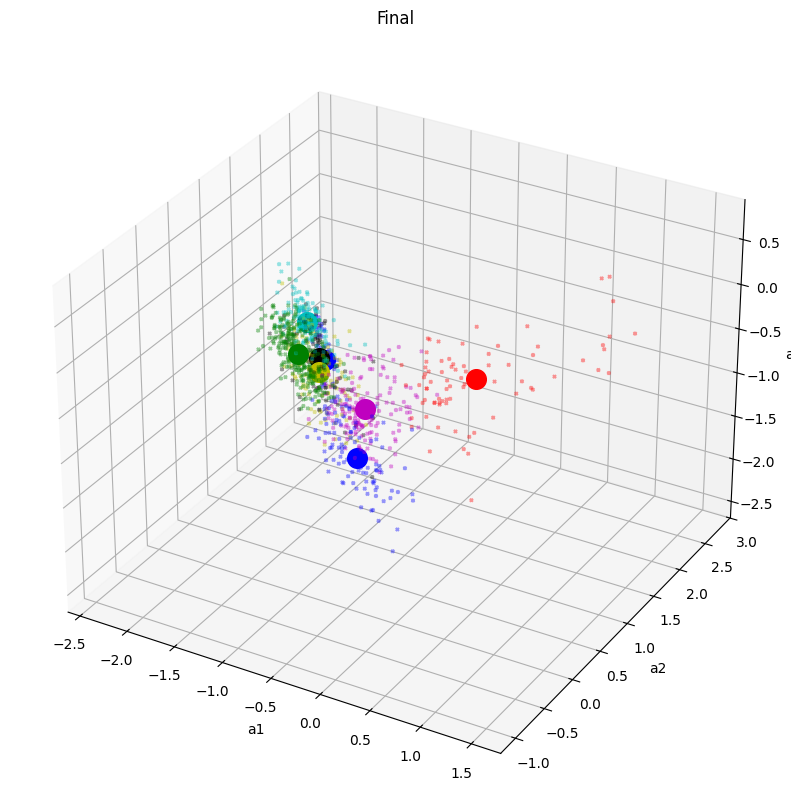

In [38]:
L = 8
data = A
show = False
codebook = data[np.random.randint(data.shape[0], size=L)] # random initialization
print(codebook.shape)
for i in range(20):
    idx_s, gd = zre.vq_code(data, codebook)
    if show:
        zre.show(data, codebook, idx_s, title=f'Iteration {i}')
    codebook, nbs = zre.vq_clust(data, idx_s, L)
    print(f'Global distance: {gd}')
    print(f'Vectors per codebook: {nbs}', end='\r')
zre.show(data, codebook, idx_s, title=f'Final')


## 2.2 Train a Codebook with Linde-Buzo-Gray initialization
L = 64 splitting the codebook 1 -> 2 -> .. 64 using vq_split - function zre.lbg does all the work°

Codebook len: 1, initial global distance: 3.02
Codebook len: 2, initial global distance: 1.48
Codebook len: 4, initial global distance: 1.09
Codebook len: 8, initial global distance: 0.79
Codebook len: 16, initial global distance: 0.59
Codebook len: 32, initial global distance: 0.42
Codebook len: 64, initial global distance: 0.31
Codebook len: 64, final global distance: 0.22


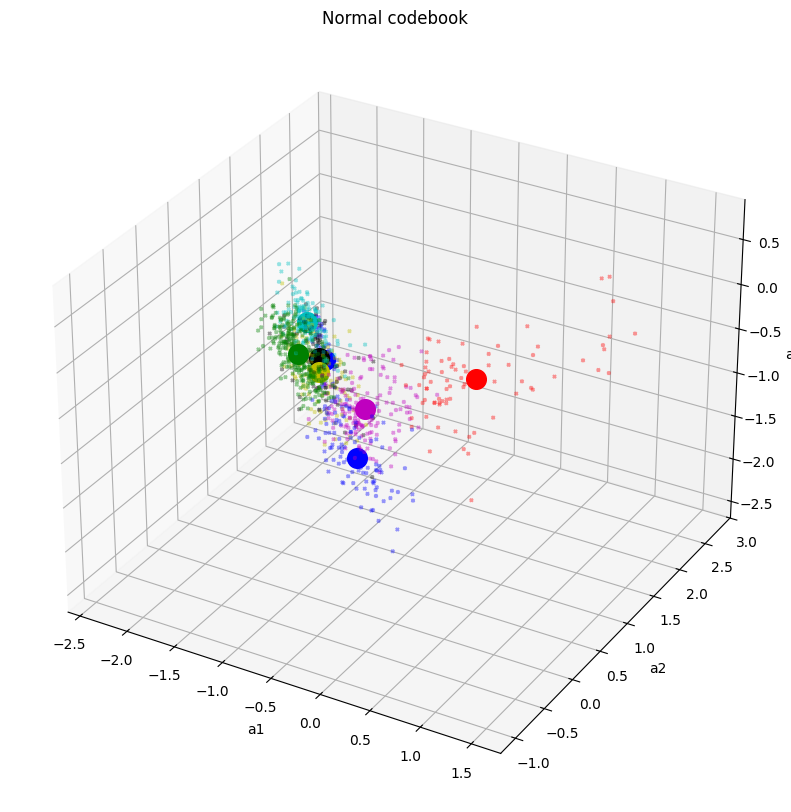

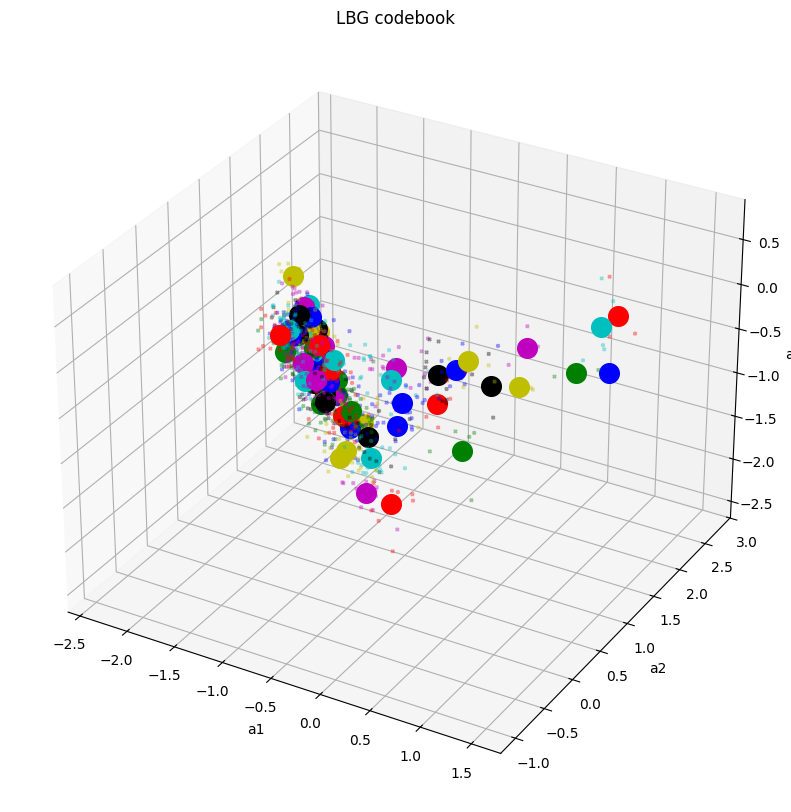

Normal gd: 0.5846325336704637, LBG gd: 0.22457819861255077


In [39]:
lbg_codebook = zre.lbg(data, 64, error=0.005)
lbg_idx_s, lbg_gd = zre.vq_code(data, lbg_codebook)
zre.show(data, codebook, idx_s, title=f'Normal codebook')
zre.show(data, lbg_codebook, lbg_idx_s, title=f'LBG codebook')
print(f'Normal gd: {gd}, LBG gd: {lbg_gd}')

# PART 3: Signal synthesis from LPC coefficients using VQ

Using VQ we have decreased the bit rate from 10x8x8 to 6bit/frame. We use the coefficients from zre.vq_code to decode using the right codebook. Try for L = 8 and L = 64 and listen to the result.

Codebook len: 1, initial global distance: 3.02
Codebook len: 2, initial global distance: 1.48
Codebook len: 4, initial global distance: 1.09
Codebook len: 8, initial global distance: 0.79
Codebook len: 8, final global distance: 0.60
Codebook len: 8, initial global distance: 0.60
Codebook len: 16, initial global distance: 0.59
Codebook len: 32, initial global distance: 0.42
Codebook len: 64, initial global distance: 0.30
Codebook len: 64, final global distance: 0.22
Global distance8: 0.5793904927900527, Global distance64: 0.3015994760719374


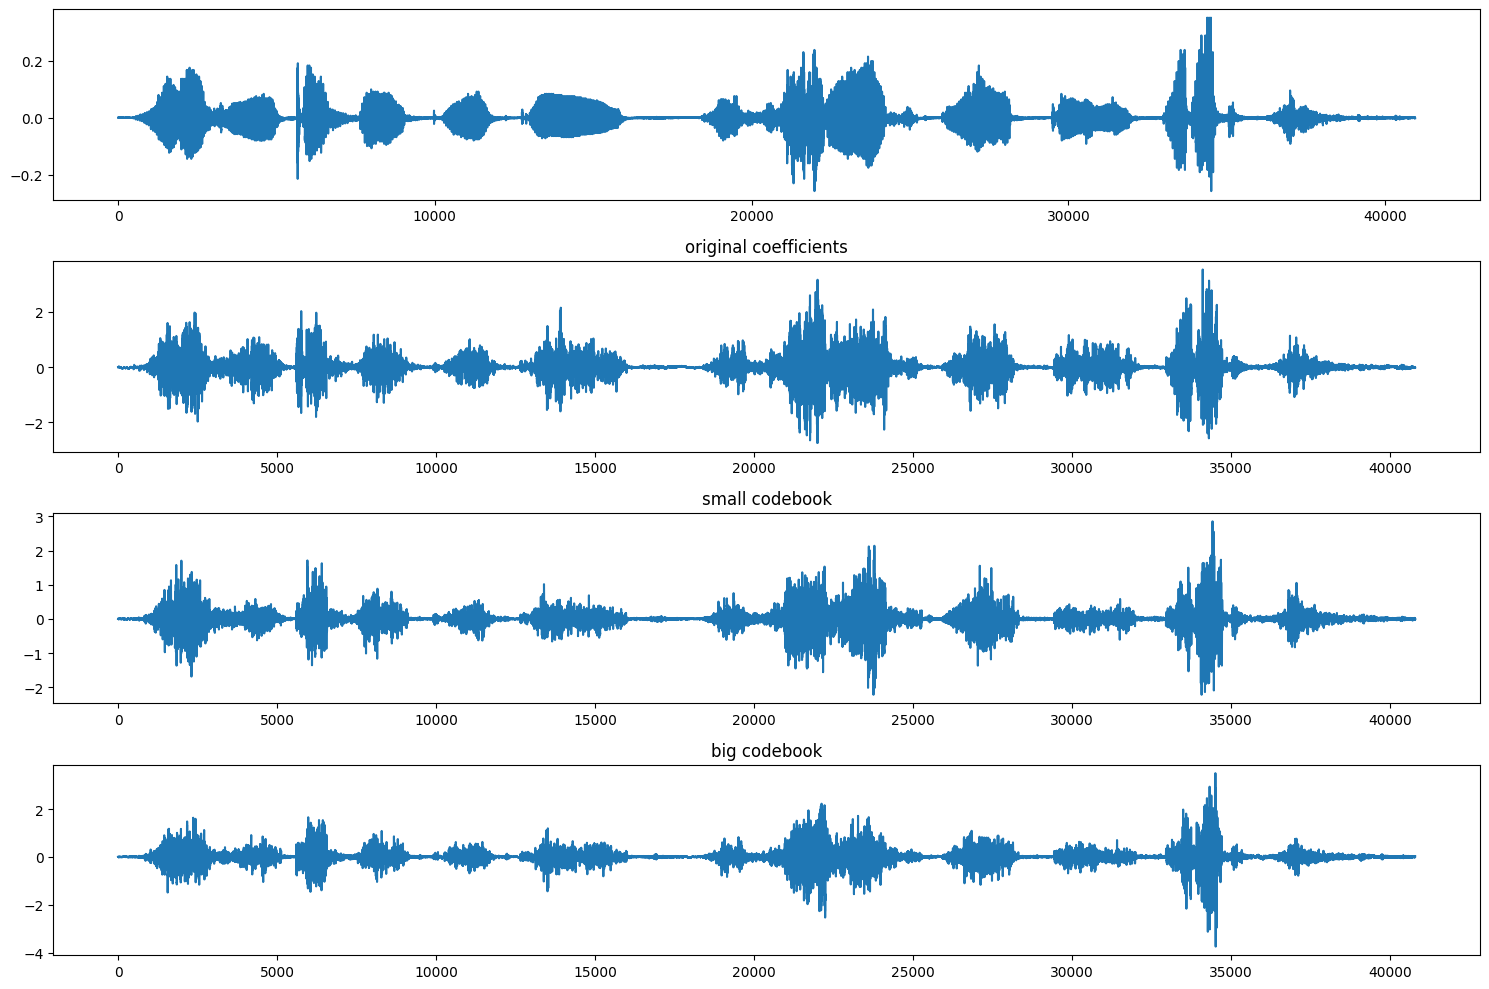

In [40]:
importlib.reload(zre)
fig, ax = plt.subplots(4,1, figsize=(15,10))
ax[0].plot(x_test)

# original coefficients
sst = zre.syntnoise(At, Gt, lcp_l, 160)
ax[1].plot(sst)
ax[1].set_title('original coefficients')

# small codebook
cb8 = zre.lbg(A, 8, error=0.001)
cb8_idx, gd8 = zre.vq_code(At, cb8)
At_decoded8 = cb8[cb8_idx]
sstdec = zre.syntnoise(At_decoded8, Gt, lcp_l, 160)
ax[2].plot(sstdec)
ax[2].set_title('small codebook')

# big codebook
cb64 = zre.lbg(A, 64, error=0.001, init_codebook=cb8)
cb64_idx, gd64 = zre.vq_code(At, cb64)
At_decoded64 = cb64[cb64_idx]
sstdec64 = zre.syntnoise(At_decoded64, Gt, lcp_l, 160)
ax[3].plot(sstdec64)
ax[3].set_title('big codebook')

print(f'Global distance8: {gd8}, Global distance64: {gd64}')

plt.tight_layout()
plt.show()


In [41]:
Audio(x_test, rate=Fs)

In [42]:
Audio(sst, rate=Fs)

In [43]:
Audio(sstdec, rate=Fs)

In [44]:
Audio(sstdec64, rate=Fs)

#### Q1 : How does the decoding work? Explain the code line `Atdecoded8 = codebook[cb8_idx]`

Decoded LPC coefficients (A(z) filter coefficients) are saved in `At_decoded8` based on `cb8_idx`, which are indexes of codevectors in the codebook.

#### Q2 : Are both the codebook filters stable? How do you recognize it?

They are. They need to be so the signal is resynthesized properly. We can also check it manually if not sure by checking if all coefficients are < 1.

#### Q3 : Why is the global distance higher then during training?

The training data probably does not fit the testing data it is later used on.